In [2]:
from datasets import load_dataset
labeled_ds = load_dataset("tianharjuno/twitter-parse", cache_dir="cache/", split="source_labeled")

In [3]:
relevant_ds = labeled_ds.filter(lambda x: x["relevant"]== True)

In [5]:
import pandas as pd

# 1. Preprocessing: Time conversion and Label Mapping
# df = ds.to_pandas() # If not already a dataframe
df = relevant_ds.to_pandas()
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

# Map integers to labels for clearer column names (Optional)
# This ensures your output columns are named 'negative', 'neutral', 'positive'
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['sentiment_label'] = df['sentiment'].map(sentiment_map)

# 2. Calculate Daily Sentiment Ratios (Distribution)
# This computes P(Sentiment | Day)
daily_ratios = pd.crosstab(
    index=df['date'],
    columns=df['sentiment_label'],
    normalize='index' # Normalizes across the row so sum is 1.0
)

# Ensure all columns exist (fill with 0 if a sentiment is missing on some days)
expected_cols = ['negative', 'neutral', 'positive']
for col in expected_cols:
    if col not in daily_ratios.columns:
        daily_ratios[col] = 0.0

# Reorder for consistency
daily_ratios = daily_ratios[expected_cols]

# 3. (Optional) Calculate a Single Net Sentiment Metric
# Common research metric: (Positive - Negative)
# Since these are ratios, this value ranges from -1 (All Negative) to +1 (All Positive)
daily_ratios['net_sentiment'] = daily_ratios['positive'] - daily_ratios['negative']

print(daily_ratios.head())

sentiment_label  negative  neutral  positive  net_sentiment
date                                                       
2009-08-06            0.0      1.0       0.0            0.0
2009-09-27            1.0      0.0       0.0           -1.0
2009-11-24            1.0      0.0       0.0           -1.0
2009-11-27            1.0      0.0       0.0           -1.0
2009-11-29            1.0      0.0       0.0           -1.0


In [11]:
import pandas as pd
import numpy as np

# 1. Load and Preprocess (Assuming relevant_ds is your HuggingFace dataset)
df = relevant_ds.to_pandas()
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# 2. Resample by Week to get Raw Counts for each sentiment
# This creates a dataframe with columns: 0 (Neg), 1 (Neu), 2 (Pos)
weekly_counts = df.groupby('sentiment')['content'].resample('W').count().unstack(level=0)

# Fill zeros for weeks with no tweets
weekly_counts = weekly_counts.fillna(0)

# Rename columns for clarity
sentiment_map = {0: 'count_neg', 1: 'count_neu', 2: 'count_pos'}
weekly_counts.rename(columns=sentiment_map, inplace=True)

# 3. Calculate Derived Metrics
# Total Volume per week
weekly_counts['relevant'] = weekly_counts['count_pos'] + weekly_counts['count_neu'] + weekly_counts['count_neg']

# Net Sentiment Score (Formula: (Pos - Neg) / Total)
# Range: -1.0 (All Negative) to +1.0 (All Positive)
# We use np.where to handle division by zero (empty weeks)
weekly_counts['sentiment_score'] = np.where(
    weekly_counts['relevant'] > 0,
    (weekly_counts['count_pos'] - weekly_counts['count_neg']) / weekly_counts['relevant'],
    0.0 # Default to neutral if no data
)

# 4. Apply Bayesian Weighting (Normalization by Data Availability)
# This dampens the score if volume is low
C = 500 # Confidence Threshold
weekly_counts['trust_factor'] = weekly_counts['relevant'] / (weekly_counts['relevant'] + C)
weekly_counts['weighted_sentiment'] = weekly_counts['sentiment_score'] * weekly_counts['trust_factor']

# 5. Filter for Date Range (Optional)
start_date = '2023-01-01'
weekly_data = weekly_counts[weekly_counts.index >= start_date].copy()

# Output check
print(weekly_data[['relevant', 'sentiment_score', 'weighted_sentiment']].tail())

sentiment   relevant  sentiment_score  weighted_sentiment
time                                                     
2025-10-05       0.0         0.000000            0.000000
2025-10-12       0.0         0.000000            0.000000
2025-10-19       3.0         0.000000            0.000000
2025-10-26       6.0        -0.666667           -0.007905
2025-11-02       1.0         0.000000            0.000000


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Processing (Assuming 'weekly_data' exists from previous step) ---
# weekly_data has columns: ['sentiment_score', 'relevant']

# Define Confidence Constant C
# C = 500 means: "We dampen the score heavily until volume > 500"
# Since your spike is 50k, C=500 is a safe threshold to filter the "noise" years.
C = 500

# Calculate the Weighting Factor (0.0 to 1.0)
weekly_data['trust_factor'] = weekly_data['relevant'] / (weekly_data['relevant'] + C)

# Apply Weighting
weekly_data['weighted_sentiment'] = weekly_data['sentiment_score'] * weekly_data['trust_factor']

# --- 2. Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Weighted Sentiment
ax1.plot(weekly_data.index,
         weekly_data['weighted_sentiment'],
         label=f'Volume-Weighted Sentiment (C={C})',
         color='royalblue',
         linewidth=2.5)

# Zero Line
ax1.axhline(0, color='white', linestyle='--', linewidth=0.8, alpha=0.5)

# Fill Areas
ax1.fill_between(weekly_data.index, weekly_data['weighted_sentiment'], 0,
                 where=(weekly_data['weighted_sentiment'] > 0),
                 facecolor='green', alpha=0.3, interpolate=True)
ax1.fill_between(weekly_data.index, weekly_data['weighted_sentiment'], 0,
                 where=(weekly_data['weighted_sentiment'] <= 0),
                 facecolor='red', alpha=0.3, interpolate=True)

ax1.set_ylabel('Weighted Sentiment Score', color='royalblue', fontsize=12)
ax1.set_ylim(-1.0, 1.0)
ax1.grid(True, linestyle=':', alpha=0.3)

# Plot Volume (Log Scale) for context
ax2 = ax1.twinx()
ax2.fill_between(weekly_data.index,
                 weekly_data['relevant'],
                 color='darkorange',
                 alpha=0.15,
                 label='Tweet Volume')
ax2.set_yscale('log')
ax2.set_ylabel('Volume (Log Scale)', color='darkorange')

plt.title('Sentiment Intensity (Normalized by Data Availability)', fontsize=14)
plt.show()

NameError: name 'weekly_data' is not defined

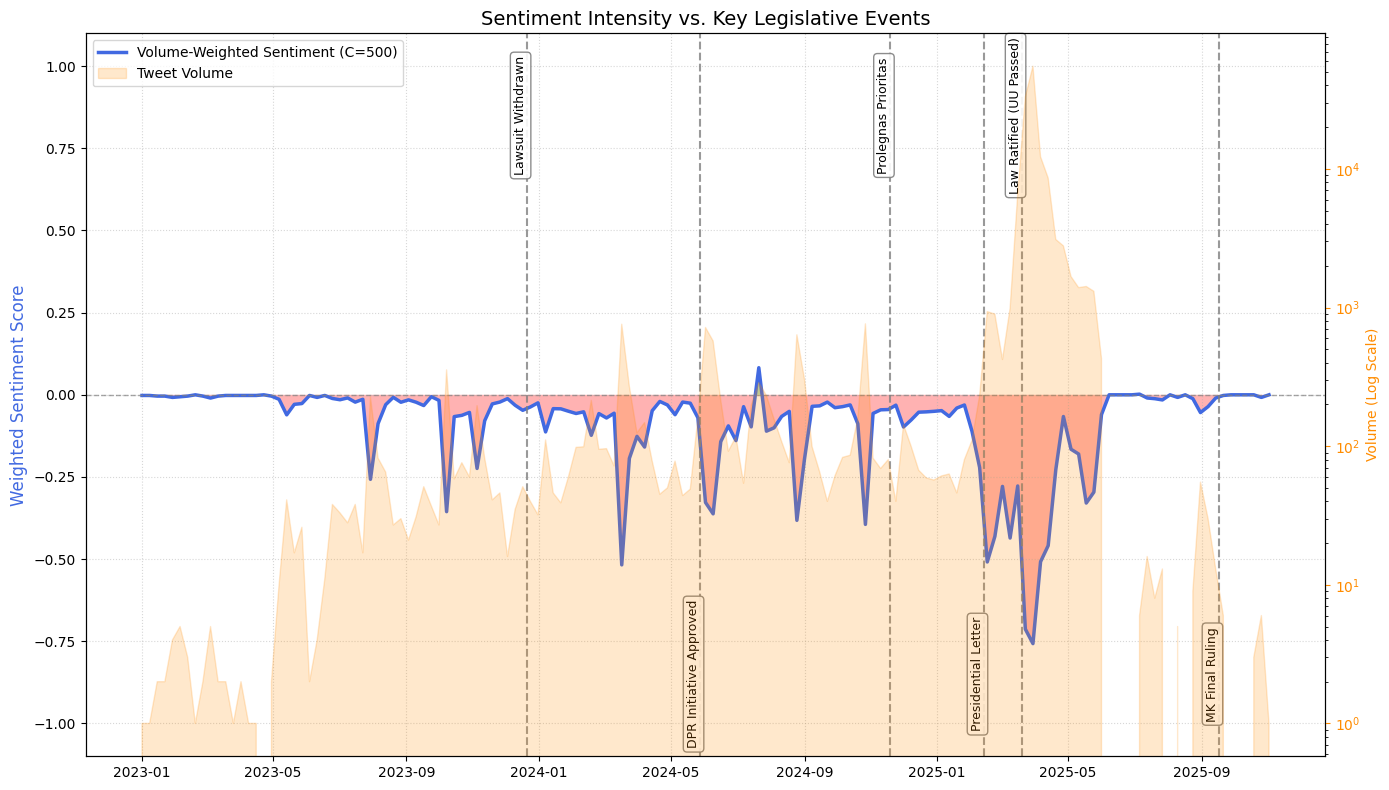

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- O. Ensure Light Theme ---
# Reset matplotlib to default white background style
plt.style.use('default')

# --- 1. Event Data Array (Phase 2 Revision Timeline) ---
key_events = [
    {"date": "2023-12-21", "label": "Lawsuit Withdrawn"},
    {"date": "2024-05-28", "label": "DPR Initiative Approved"},
    {"date": "2024-11-19", "label": "Prolegnas Prioritas"},
    {"date": "2025-02-13", "label": "Presidential Letter"},
    {"date": "2025-03-20", "label": "Law Ratified (UU Passed)"},
    {"date": "2025-09-17", "label": "MK Final Ruling"}
]

# --- 2. Processing (Your Existing Logic) ---
# Assuming 'weekly_data' exists and has columns: ['sentiment_score', 'relevant']
# Assuming weekly_data index is already datetime from previous steps

C = 500
weekly_data['trust_factor'] = weekly_data['relevant'] / (weekly_data['relevant'] + C)
weekly_data['weighted_sentiment'] = weekly_data['sentiment_score'] * weekly_data['trust_factor']

# --- 3. Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Weighted Sentiment
ax1.plot(weekly_data.index,
         weekly_data['weighted_sentiment'],
         label=f'Volume-Weighted Sentiment (C={C})',
         color='royalblue',
         linewidth=2.5,
         zorder=2)

# Zero Line (Changed color to gray for light mode)
ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Fill Areas
ax1.fill_between(weekly_data.index, weekly_data['weighted_sentiment'], 0,
                 where=(weekly_data['weighted_sentiment'] > 0),
                 facecolor='green', alpha=0.3, interpolate=True)
ax1.fill_between(weekly_data.index, weekly_data['weighted_sentiment'], 0,
                 where=(weekly_data['weighted_sentiment'] <= 0),
                 facecolor='red', alpha=0.3, interpolate=True)

ax1.set_ylabel('Weighted Sentiment Score', color='royalblue', fontsize=12)
ax1.set_ylim(-1.1, 1.1)
ax1.grid(True, linestyle=':', alpha=0.5) # Slightly darker grid for visibility

# Plot Volume (Log Scale)
ax2 = ax1.twinx()
ax2.fill_between(weekly_data.index,
                 weekly_data['relevant'],
                 color='darkorange',
                 alpha=0.2, # Slightly higher alpha for visibility on white
                 label='Tweet Volume')
ax2.set_yscale('log')
ax2.set_ylabel('Volume (Log Scale)', color='darkorange')
# Ensure right y-axis ticks use the correct color
ax2.tick_params(axis='y', colors='darkorange')


# --- NEW: Add Vertical Bars for Events ---
for i, event in enumerate(key_events):
    event_date = pd.to_datetime(event['date'])

    # Only plot if event is within the data range
    if event_date >= weekly_data.index.min() and event_date <= weekly_data.index.max():
        # 1. Draw Vertical Line (Changed to gray)
        ax1.axvline(x=event_date, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)

        # 2. Add Label (Staggered height to avoid overlap)
        y_pos = 0.85 if i % 2 == 0 else -0.85

        ax1.text(x=event_date,
                 y=y_pos,
                 s=event['label'],
                 rotation=90,
                 color='black', # Changed text to black
                 fontsize=9,
                 ha='right',
                 va='center',
                 # Changed box to white face, gray edge
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

plt.title('Sentiment Intensity vs. Key Legislative Events', fontsize=14)

# Combine Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()